Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [434]:
airbnb <-read.csv('airbnb-listings.csv',
                  sep = ';')
options(repr.plot.height=4,
        repr.plot.width=6,
        repr.plot.res = 300)

In [435]:
library(dplyr)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [436]:
airbnb <- airbnb[c('City',
                   'Room.Type',
                   'Neighbourhood',
                   'Accommodates',
                   'Bathrooms',
                   'Bedrooms',
                   'Beds',
                   'Price',
                   'Square.Feet',
                   'Guests.Included',
                   'Extra.People',
                   'Review.Scores.Rating',
                   'Latitude', 
                   'Longitude')]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [437]:
library(dplyr)
df_madrid <- airbnb |>
        filter(City=='Madrid',
        Room.Type=='Entire home/apt',
        Neighbourhood != '') |>
        select(-Room.Type,-City) #No son necesarias: "Room.Type",'City'

Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [438]:
x = 0.092903
df_madrid$Square.Meters <- df_madrid$Square.Feet * x

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [439]:
x <- sum(is.na(df_madrid$Square.Meters))
y <- length(df_madrid$Square.Meters)
na_porcenje <- (x/y)*100

paste("porcentaje de los apartamentos no muestran los metros cuadrados:")
paste(round(na_porcenje,2),"%")

[1] "porcentaje de los apartamentos no muestran los metros cuadrados:"

[1] "93.8 %"

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [440]:
x <- length(which(df_madrid$Square.Meters == 0))
y <- sum(!is.na(df_madrid$Square.Meters))
zero_count <- (x/y)*100
paste("porcentaje de los apartamentos tienen 0 metros cuadrados:")
paste(round(zero_count,2),"%")

[1] "porcentaje de los apartamentos tienen 0 metros cuadrados:"

[1] "36.89 %"

Reemplazar todos los 0m^2 por NA 

In [441]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5382 rows containing non-finite values (`stat_bin()`).”


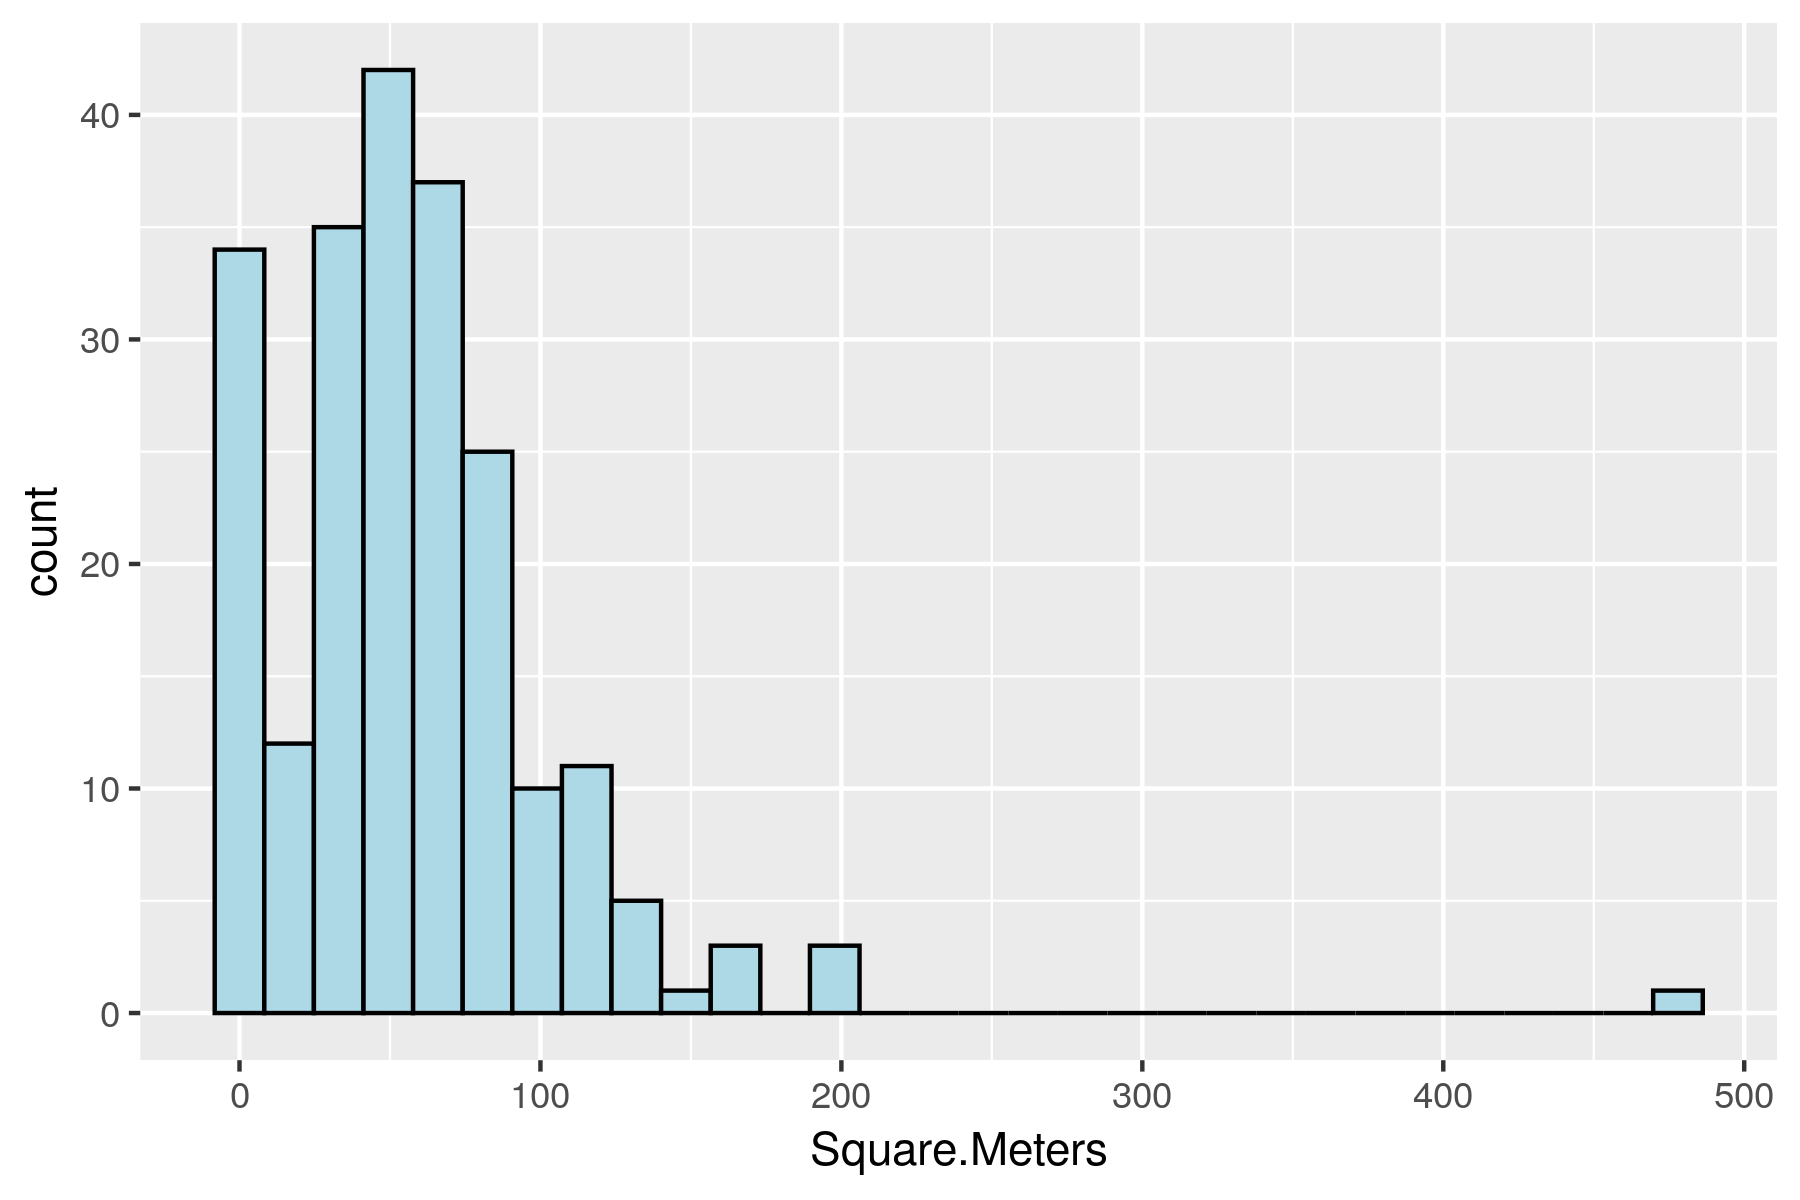

In [442]:
library(ggplot2)
options(repr.plot.height=4,repr.plot.width=6)

ggplot(data =df_madrid, aes(x=Square.Meters))+
geom_histogram(fill='lightblue', color='black')

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 5427 rows containing non-finite values (`stat_bin()`).”


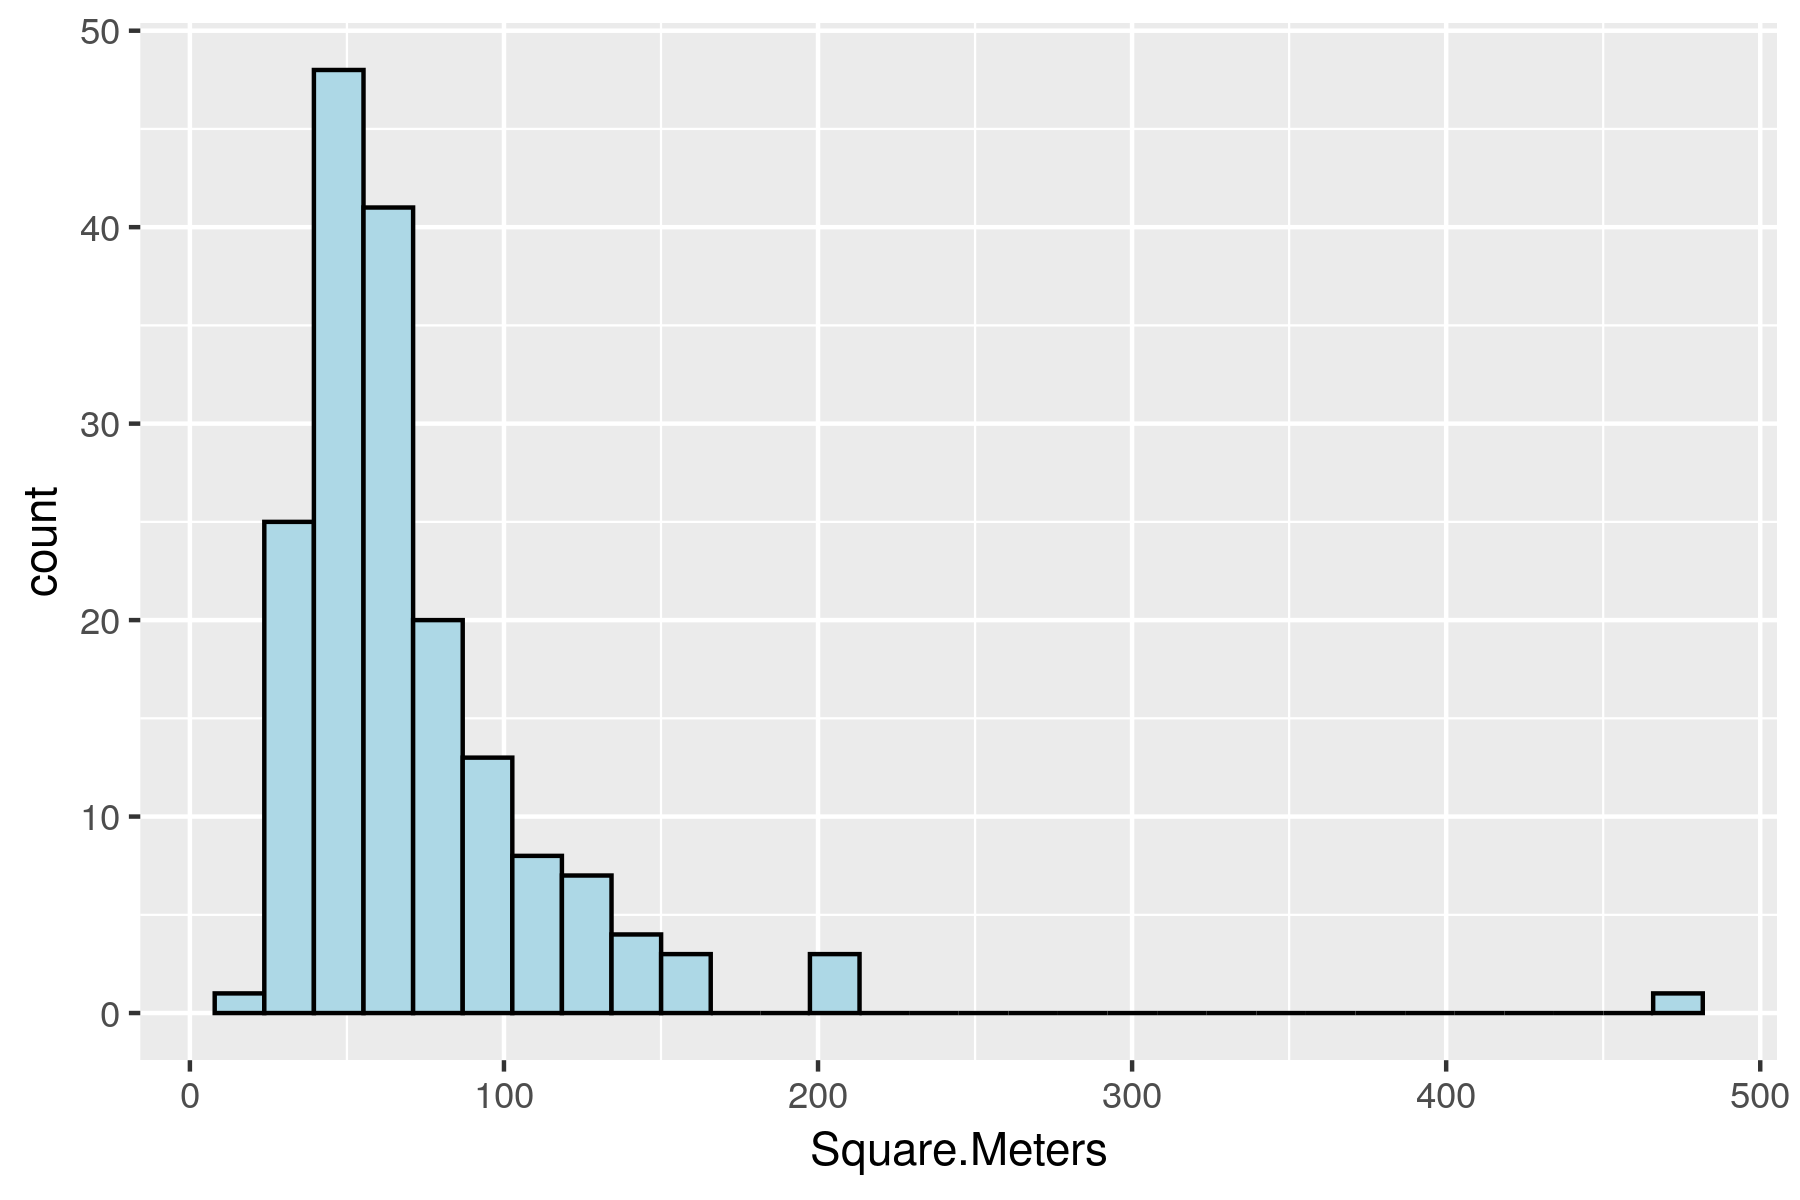

In [443]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA
library(ggplot2)
options(repr.plot.height=4,repr.plot.width=6)

ggplot(data =df_madrid, aes(x=Square.Meters))+
geom_histogram(fill='lightblue', color='black')

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [514]:
df_madrid |> group_by(Neighbourhood) |> 
            summarise(x=sum(!is.na(Square.Meters))) |> 
            filter(x==0) |> pull(Neighbourhood) -> listado_barrios

df_madrid <- df_madrid[!df_madrid$Neighbourhood %in% listado_barrios,]

df_madrid

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Square.Feet,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,Palacio,2,1.0,1,1,85,NA,1,0,95,40.41697,-3.709439,NA
2,Malasaña,4,1.0,1,2,112,NA,2,5,99,40.42319,-3.711249,NA
3,Palacio,8,3.0,3,4,190,NA,6,40,96,40.41651,-3.717843,NA
4,La Latina,2,1.0,1,1,71,NA,1,0,90,40.41200,-3.706691,NA
5,Embajadores,2,NA,1,NA,34,NA,1,6,88,40.40809,-3.700322,NA
6,Embajadores,3,1.0,0,2,60,NA,1,0,100,40.41085,-3.701099,NA
7,La Latina,2,1.0,0,1,45,NA,1,0,87,40.40812,-3.710367,NA
8,Embajadores,6,1.0,2,3,120,NA,6,30,100,40.41314,-3.705092,NA
9,Embajadores,4,1.0,0,2,50,NA,2,8,86,40.40988,-3.702840,NA


El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

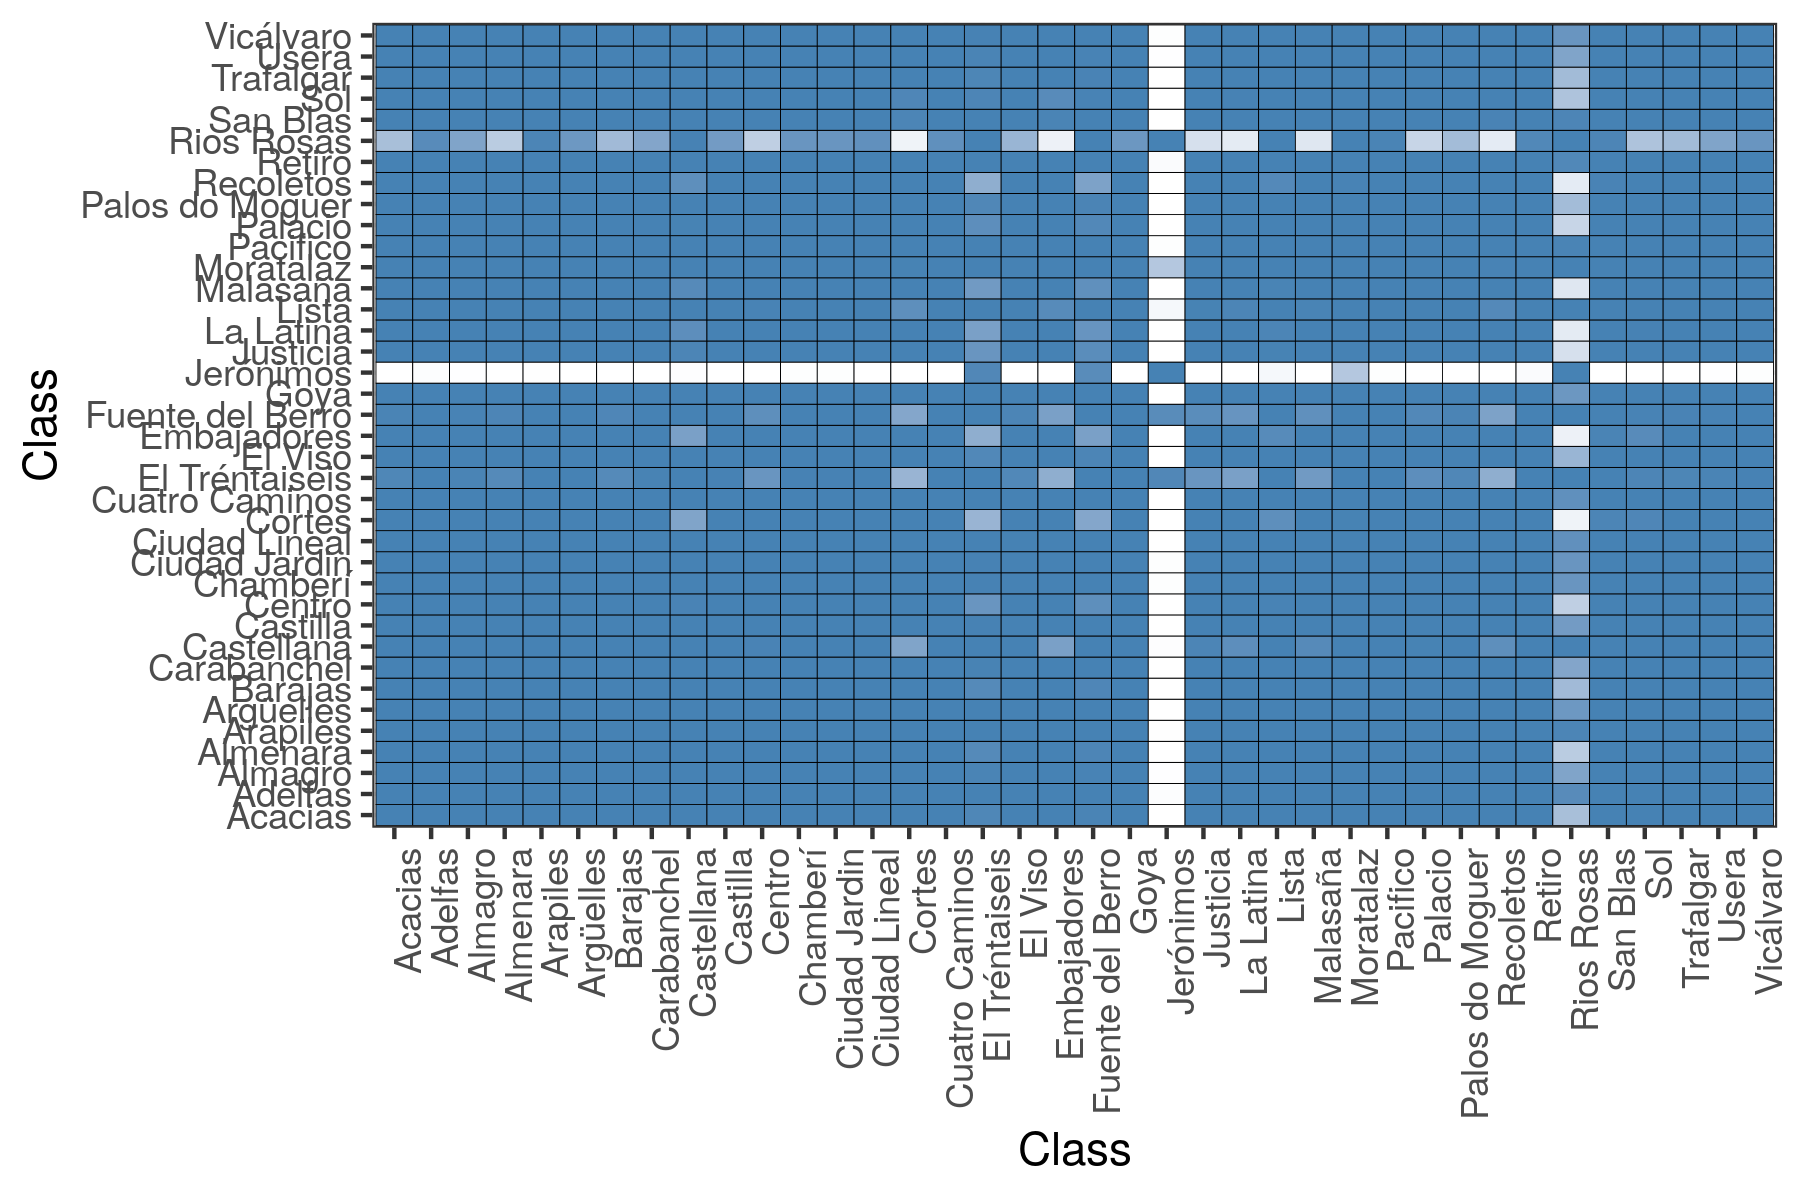

In [515]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [516]:
distancia <- 1 - resm

In [517]:
library(dendextend)
library(cluster)
library(stats)

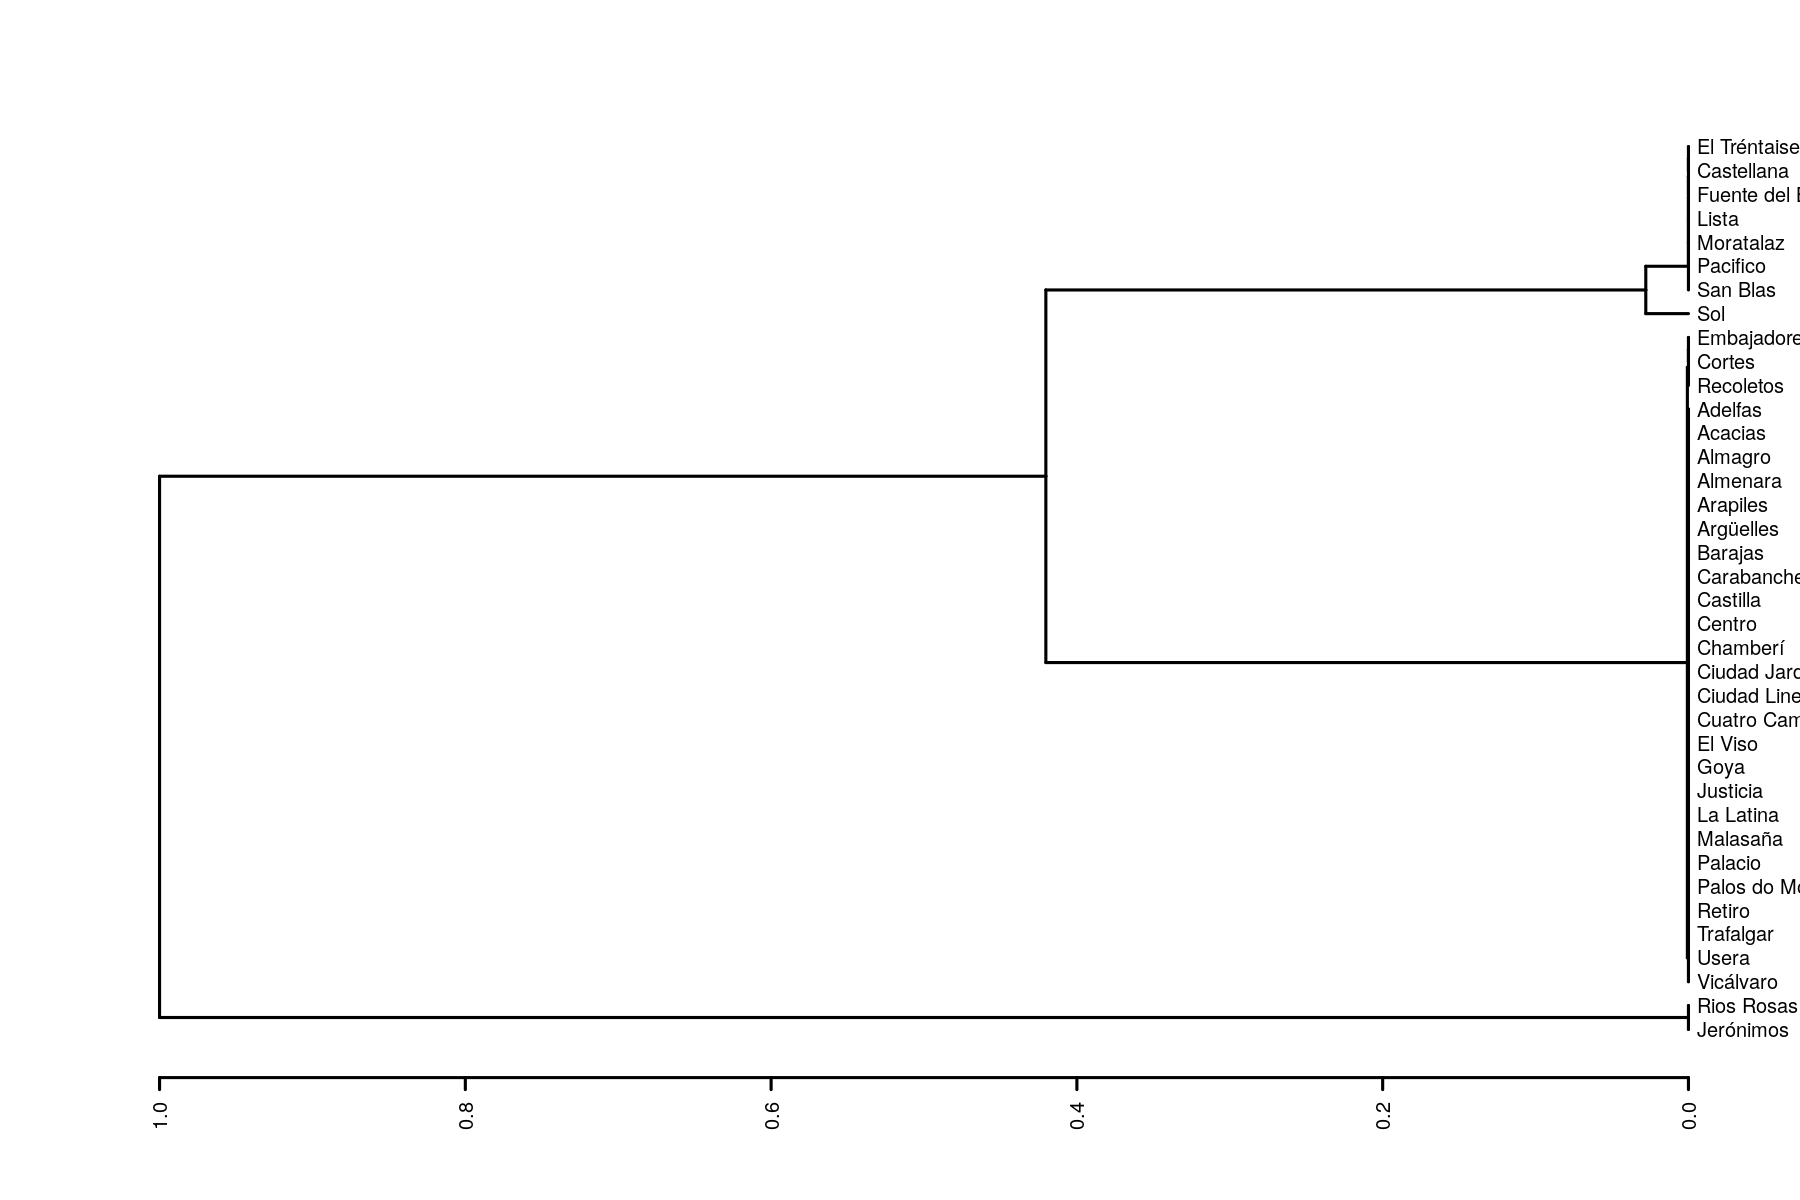

In [535]:

#distancia a matriz de distancia
distance_matrix <- as.dist(distancia)

# Calcular jerarquía de clustering
cluster <- hclust(distance_matrix, method="complete")

# Dibujar dendrograma
dendrograma <- as.dendrogram(cluster)
par(cex=0.4)
par(las=2)
plot(dendrograma,horiz=TRUE)


¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

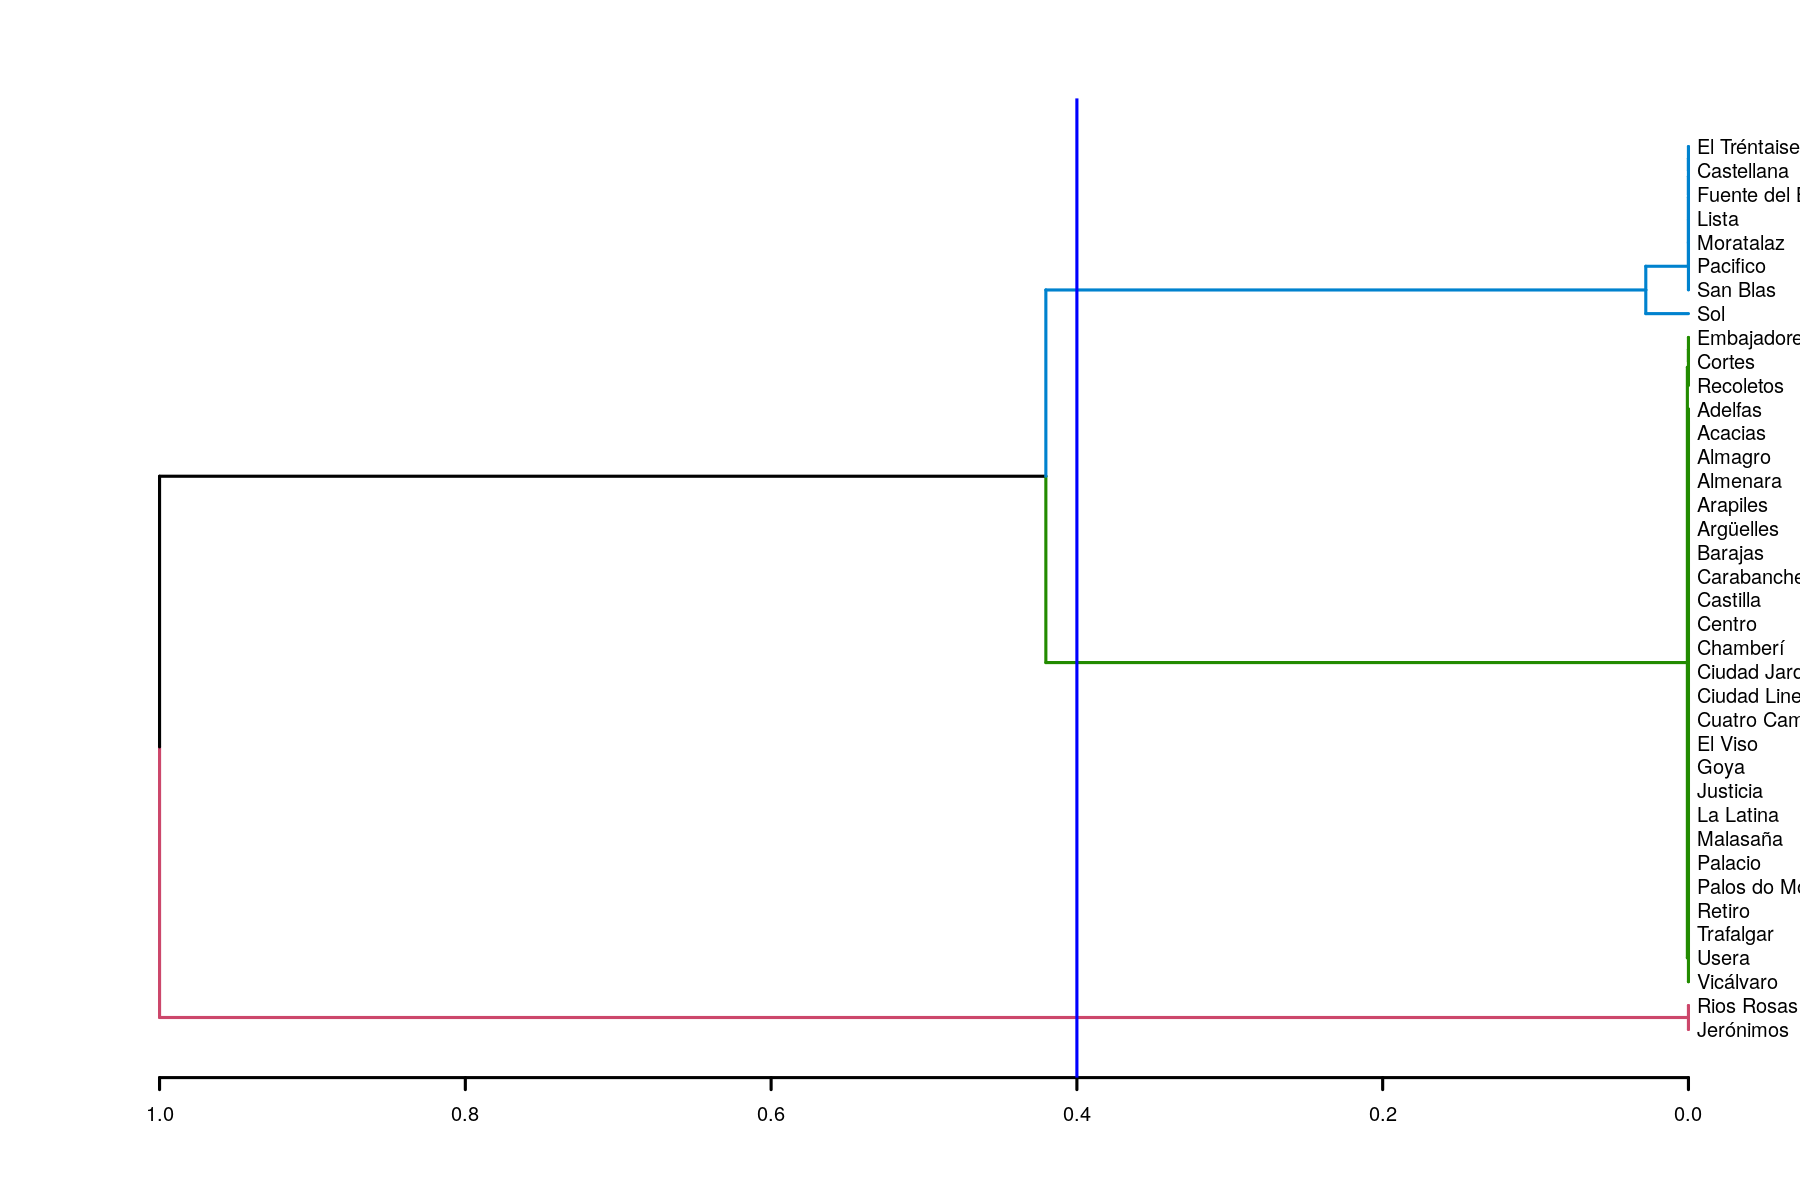

In [536]:
corte = 0.4
par(cex=0.4)
plot(color_branches(dendrograma,
                    h=corte),
                    horiz=TRUE)
abline(v=corte,col="blue")
cl <- cutree_1h.dendrogram(dendrograma,h=0.4) 

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [537]:
cl <- as.data.frame(cl ,
                    stringsAsFactors= TRUE)
colnames(cl)<-'Neighb_id'
df_madrid <- merge(df_madrid,cl,
                   by.x='Neighbourhood',
                   by.y=0)

df_madrid$Neighb_id <- as.factor(df_madrid$Neighb_id)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [667]:
library(dplyr)
df_madrid |> drop_na(Square.Meters) -> lm_madrid

In [668]:
set.seed(3)
idx<-sample(1:nrow(lm_madrid),nrow(lm_madrid)*0.7)

lm_madrid.train=lm_madrid[idx,]
lm_madrid.test=lm_madrid[-idx,]


In [669]:
#modelo sin Neighbourhood, Latitude,Longitude
m_madrid<-lm(Square.Meters~Accommodates+Bathrooms+Bedrooms+
                 Beds+Price+Guests.Included+Extra.People+
                 Review.Scores.Rating+neighb_id,
                 data=lm_madrid.train)
summary(m_madrid)


Call:
lm(formula = Square.Meters ~ Accommodates + Bathrooms + Bedrooms + 
    Beds + Price + Guests.Included + Extra.People + Review.Scores.Rating + 
    Neighb_id, data = lm_madrid.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-91.796  -9.639  -0.755  12.047 108.701 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -10.74502   25.95420  -0.414 0.679727    
Accommodates           3.73722    2.45194   1.524 0.130497    
Bathrooms             25.67736    6.05963   4.237  4.9e-05 ***
Bedrooms               8.91748    3.84274   2.321 0.022260 *  
Beds                   5.41378    2.48194   2.181 0.031416 *  
Price                  0.10971    0.05144   2.133 0.035296 *  
Guests.Included       -8.59547    2.39719  -3.586 0.000514 ***
Extra.People           0.53726    0.29089   1.847 0.067600 .  
Review.Scores.Rating   0.10199    0.27397   0.372 0.710454    
Neighb_id2            -6.17718    5.93743  -1.040 0.300576    
Neighb_i

In [675]:
m_madrid2<-lm(Square.Meters~Bathrooms+Bedrooms+
                 Beds+Price+Guests.Included+Neighb_id,
                 data=lm_madrid.train)
summary(m_madrid2)


Call:
lm(formula = Square.Meters ~ Bathrooms + Bedrooms + Beds + Price + 
    Guests.Included + Neighb_id, data = lm_madrid.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-85.213 -11.960  -0.557  12.098 117.259 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      5.92721    8.97060   0.661 0.510150    
Bathrooms       23.43218    5.91609   3.961 0.000132 ***
Bedrooms         9.77472    3.58856   2.724 0.007497 ** 
Beds             8.75004    2.02082   4.330 3.28e-05 ***
Price            0.08685    0.05045   1.721 0.087965 .  
Guests.Included -5.52352    2.26288  -2.441 0.016230 *  
Neighb_id2      -3.63227    6.04508  -0.601 0.549156    
Neighb_id3      72.97501   18.46558   3.952 0.000137 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24.95 on 111 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.7799,	Adjusted R-squared:  0.766 
F-statistic: 56.18

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

In [671]:
paste("TRAIN")
predict_madrid.train <- predict(m_madrid,lm_madrid.train)
caret::postResample(pred=predict_madrid.train, obs=lm_madrid.train$Square.Meters)


paste("TRAIN")
predict_madrid.test <- predict(m_madrid,lm_madrid.test)
caret::postResample(pred=predict_madrid.test, obs=lm_madrid.test$Square.Meters)


[1] "TRAIN"

RMSE   Rsquared        MAE 
22.8667510  0.8043121 15.5090187

[1] "TRAIN"

RMSE   Rsquared        MAE 
27.1856152  0.3573145 19.1107418

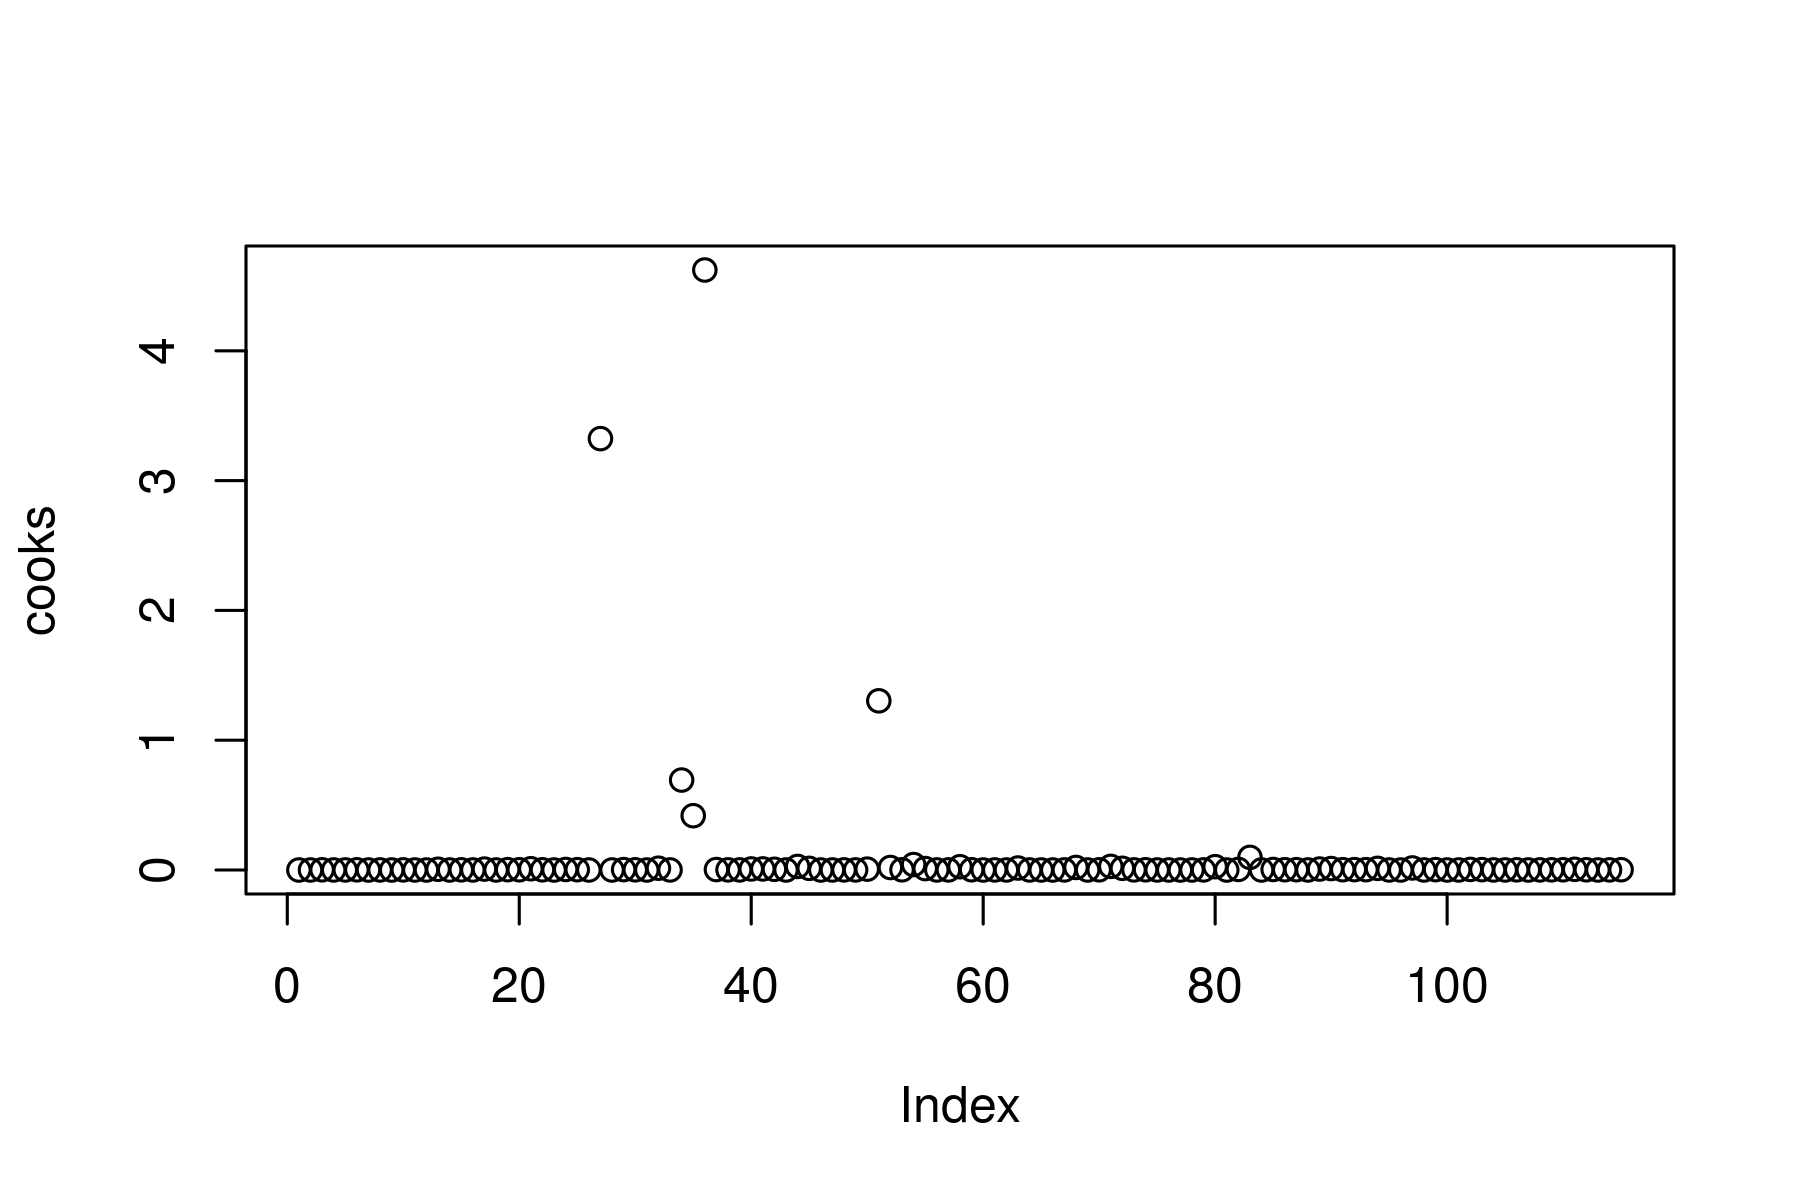

In [672]:
cooks <- cooks.distance(m_madrid)
plot(cooks)


Warning message in lm_madrid.train$Square.Meters - predict_madrid.test:
“longer object length is not a multiple of shorter object length”


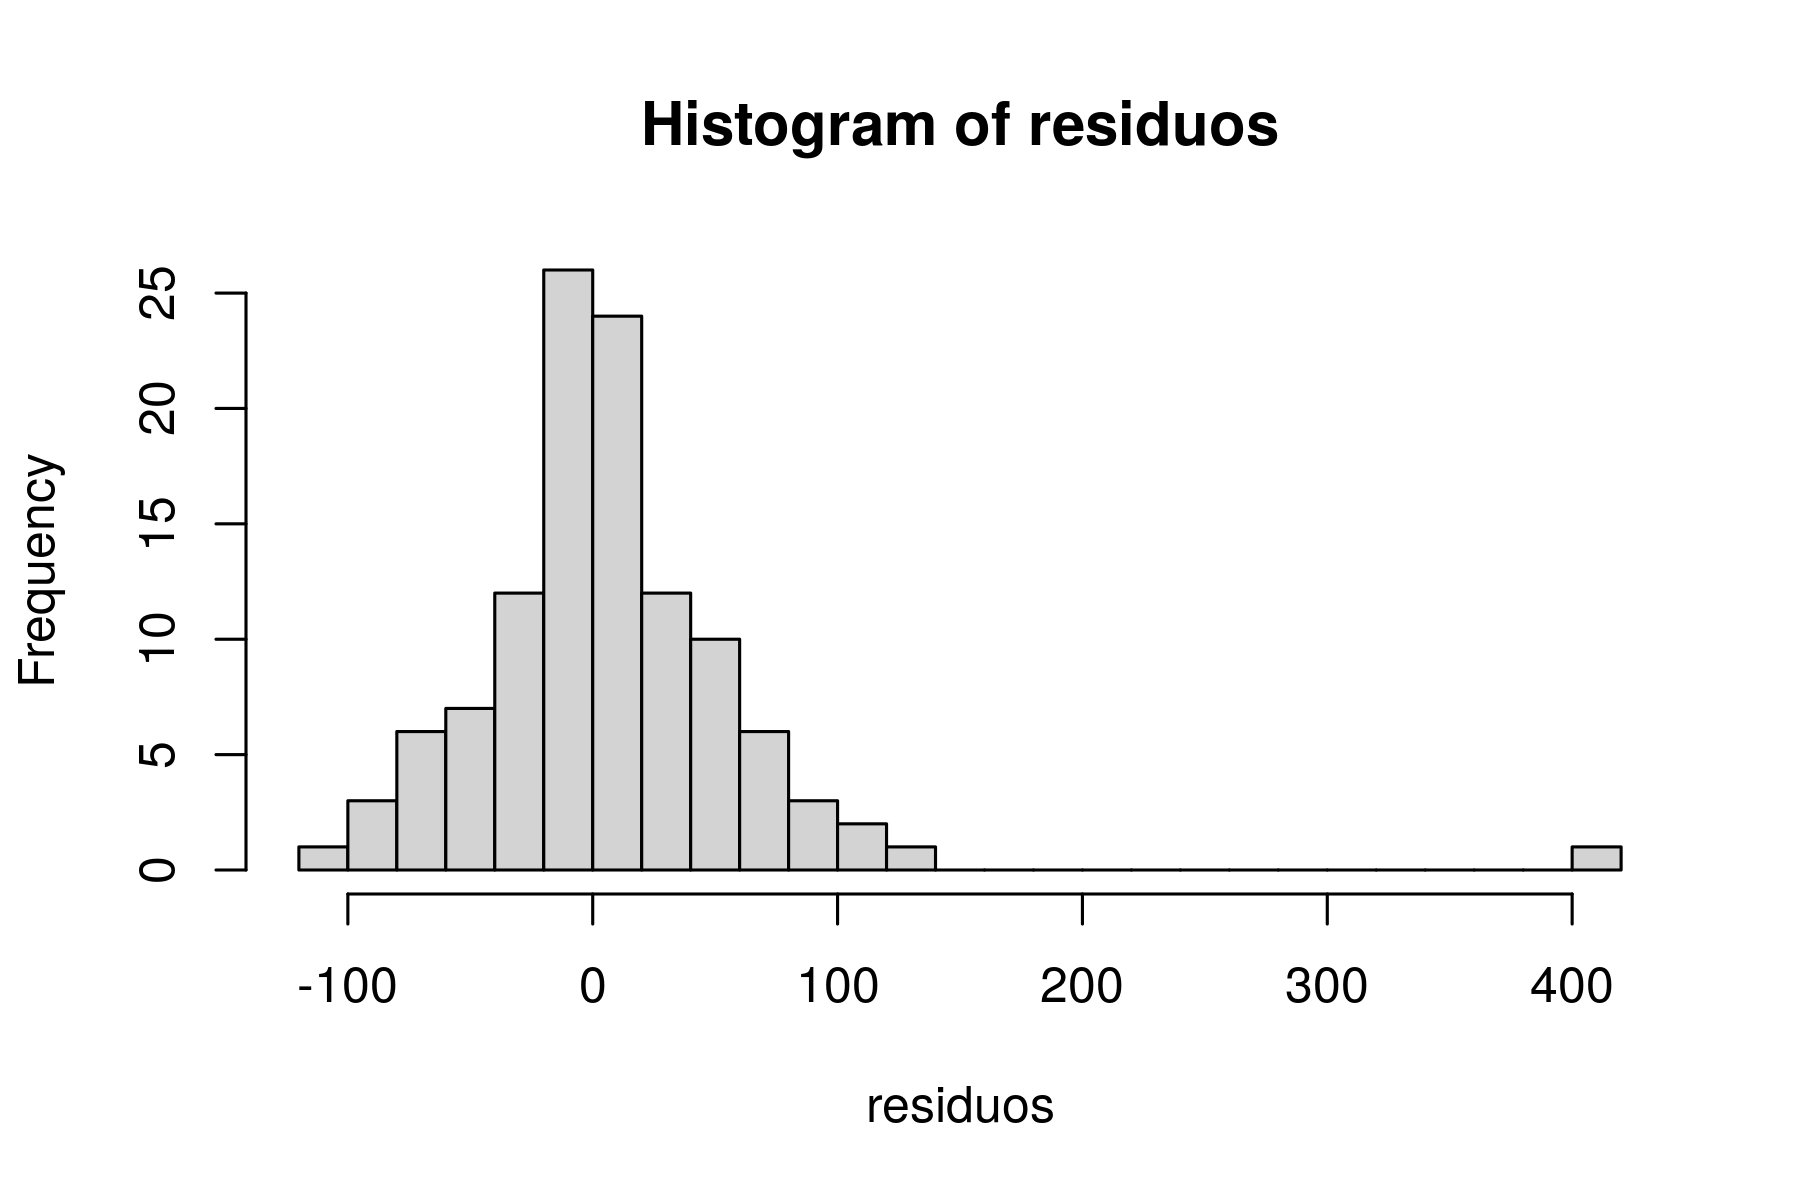

In [676]:
#representar el histograma de residuos
residuos <- lm_madrid.train$Square.Meters-predict_madrid.test
hist(residuos,30)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

In [688]:
df_mt <- data.frame(Accommodates=6,
                       Bathrooms=1,
                       Guests.Included=0,
                       Price = 80,
                       Bedrooms=3,
                       Beds=3,
                       Extra.People=0,
                       Review.Scores.Rating=80,
                       Neighb_id=as.factor(1))


In [705]:
paste(round(predict(m_madrid, df_mt),digits = 2),"mt^2 tendría la habitacion")


[1] "97.29 mt^2 tendría la habitacion"

In [723]:
paste(round(m_madrid$coefficients['Bedrooms'],digits = 2),"mt^2 aumentaria por habitación adicional")

[1] "8.92 mt^2 aumentaria por habitación adicional"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [725]:

df_madrid$Square.Meters[which(is.na(df_madrid$Square.Meters))] <- predict(m_madrid,df_madrid[which(is.na(df_madrid$Square.Meters)),])






Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?